# Import required libraries

In [1]:
# !pip install kaggle
# !pip install scikit-learn
# !pip install joblib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetV2S
from IPython.display import Image
import os
import shutil
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


2025-03-15 09:24:42.728817: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 09:24:42.728884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 09:24:42.728924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 09:24:42.738713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import dataset from Kaggle via command line

In [3]:
# os.environ["KAGGLE_USERNAME"] = "XXXXX"
# os.environ["KAGGLE_KEY"] = "XXXXX"

In [4]:
# !kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images

In [5]:
# import zipfile

# def unzip_file(zip_file_path, extract_to_path):
#     # Ensure the extraction directory exists
#     if not os.path.exists(extract_to_path):
#         os.makedirs(extract_to_path)
    
#     # Open the zip file in read mode and extract all contents
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_path)
#         print(f"Extracted all files to {extract_to_path}")

In [6]:
main_dir = './CVDATASET'
train_dataset_dir = main_dir + "/train"
test_dataset_dir = main_dir + "/test"

In [7]:
# zip_file_path = "./cifake-real-and-ai-generated-synthetic-images.zip"
# extract_to_path = main_dir
# unzip_file(zip_file_path, extract_to_path)

# Check GPU usage

In [8]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  5


# Actual model building

In [10]:
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
print(val_ds.class_names)

In [11]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [ ]:
# Load Pre-trained EfficientNetV2S Model
EffNetV2_base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
EffNetV2_base_model.trainable = False  # Freeze the base model

# Extract features using the pre-trained EfficientNetV2S model
feature_extractor = tf.keras.Model(
    inputs=EffNetV2_base_model.input, 
    outputs=EffNetV2_base_model.layers[-2].output
)

start_time = time.time()

# Convert dataset to numpy arrays
X_train = np.concatenate([feature_extractor(x) for x, _ in train_ds])
X_test = np.concatenate([feature_extractor(x) for x, _ in val_ds])

# Ensure labels are in integer format
y_train = np.concatenate([y.numpy() for _, y in train_ds])
y_test = np.concatenate([y.numpy() for _, y in val_ds])

# If labels are one-hot encoded, convert to class indices
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

# Reshape to 2D: (num_samples, num_features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [15]:
# Train Random Forest classifier and record training time
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)
train_time = time.time() - start_time

In [ ]:
# Predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)
y_train_proba = rf_classifier.predict_proba(X_train)
y_test_proba = rf_classifier.predict_proba(X_test)

y_test_proba shape: (20000, 2)


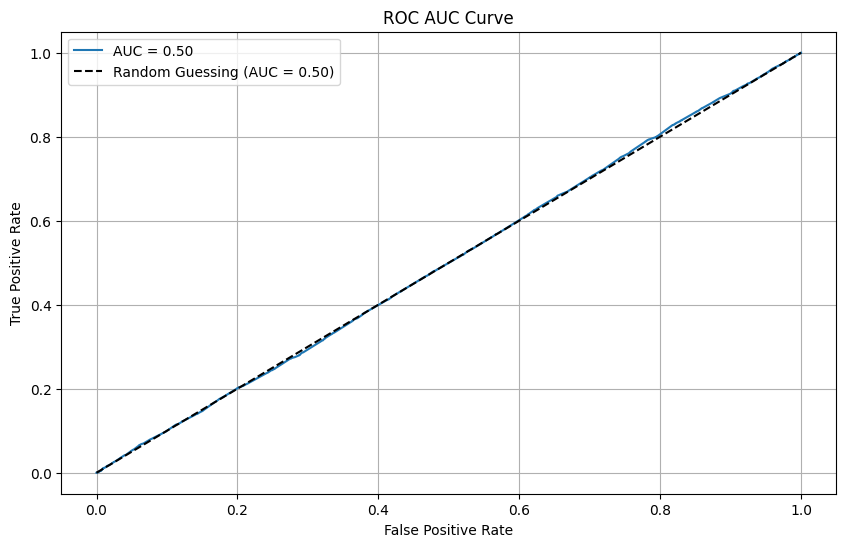

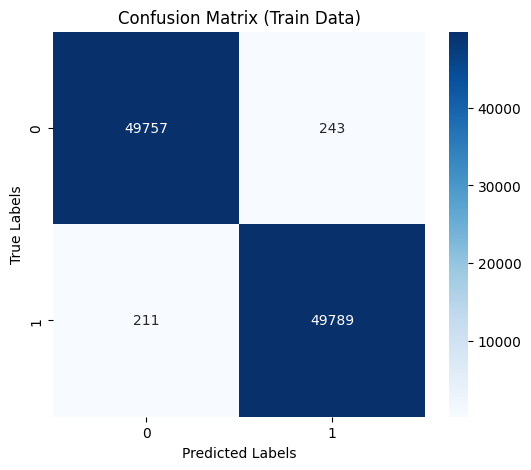

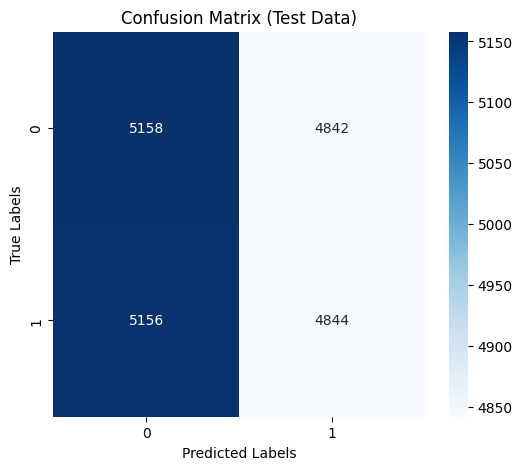

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# Get class labels
class_labels = np.unique(y_train)  # Unique class labels
n_classes = len(class_labels)

# Check the shape of y_test_proba
print("y_test_proba shape:", y_test_proba.shape)

# --- Plot ROC AUC Curves ---
plt.figure(figsize=(10, 6))

# Handle Binary Classification Case
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])  # Use the second column for positive class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

# Handle Multi-Class Classification
else:
    y_train_bin = label_binarize(y_train, classes=class_labels)
    y_test_bin = label_binarize(y_test, classes=class_labels)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend()
plt.grid()
plt.show()

# --- Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred, dataset_type="Test"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix ({dataset_type} Data)")
    plt.show()

# Plot Confusion Matrix for Training Data
plot_confusion_matrix(y_train, y_train_pred, dataset_type="Train")

# Plot Confusion Matrix for Test Data
plot_confusion_matrix(y_test, y_test_pred, dataset_type="Test")


In [ ]:
import joblib

# Save the model
joblib.dump(rf_classifier, "random_forest_model.pkl")

# Load the model later
rf_classifier_loaded = joblib.load("random_forest_model.pkl")
